In [9]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 5,5 
rcParams['figure.figsize'] = 16, 10
import scipy, scipy.stats
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)

%config InlineBackend.figure_format = 'retina'


Let's load the distributions and plot the CDFs

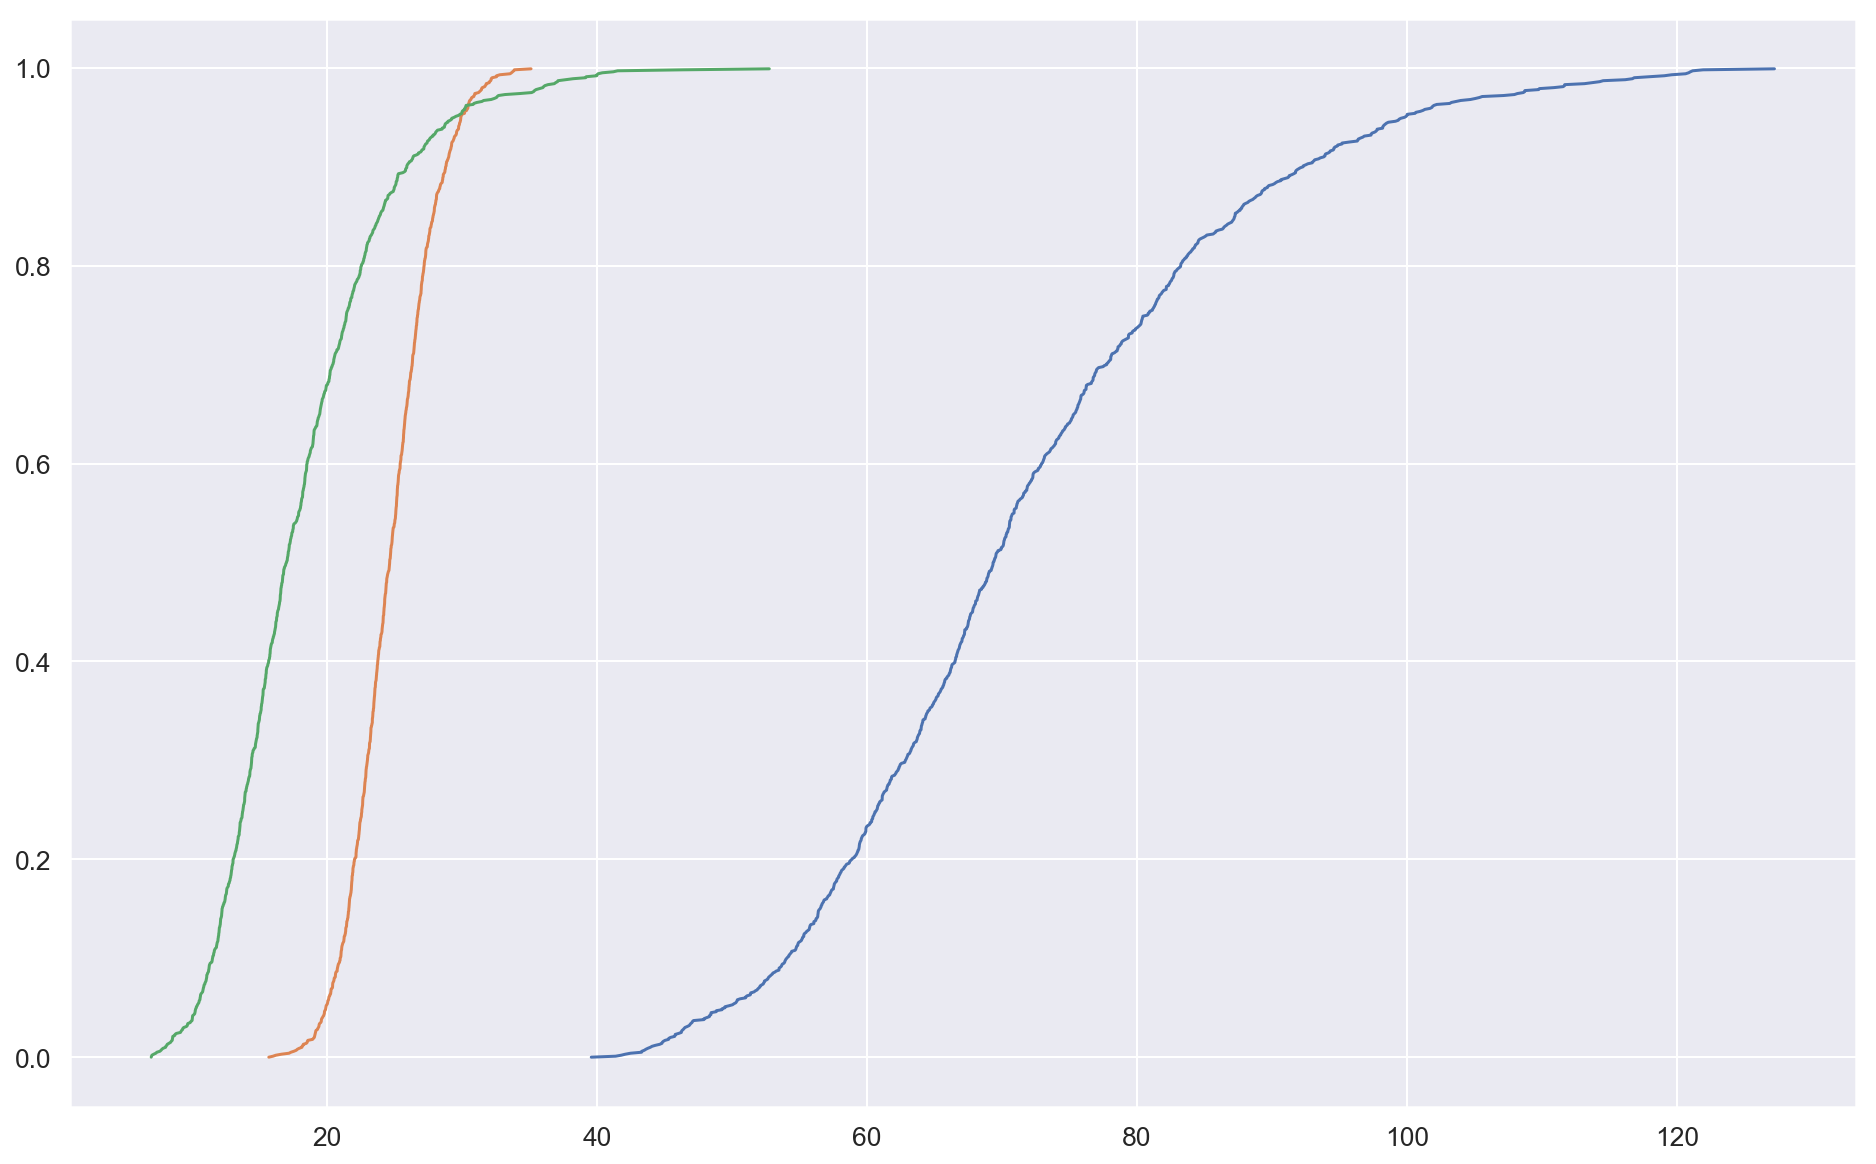

In [5]:
import json

with open('dist.json') as f:
    data = json.load(f)

for dist in data:
    xs, ys = dist['data']['xs'], dist['data']['ys']
    sns.lineplot(xs, ys)
    
    

Let's make a class CDF that will hold the spec in a vector pair (x, F), which is equivalent to xs and ys from the input.

The class method __combine__ will take a list of CDF objects and return a new CDF object holding the combined distribution. For now it just uses the same weights for each CDF.

The instance method __rvs__ returns a numpy array of __n__ random variates from the CDF.


In order to combine $k$ CDFs $F_{1}(x),F_{2}(x)...F_{k}(x)$ into the combined CDF $F_c$, with assigned weights $w_1, w_2...w_k$, we can use the following formula
$$F_{c}(x)=\sum_{j=1}^{k}w_{j}\cdot F_{j}(x)$$
It is easy to prove that this F_c is actually the CDF of a mixture of distributions given by $ F_{1}(x),F_{2}(x)...F_{k}(x) $.

Since our CDFs are given at discrete sampled points along $x$, we'll evaluate the sum above for every $x$ appearing in all of the input CDFs. This means that in the end we can end up with $k\cdot N$ points for $F_c$, but there are ways to reduce that number.

Another problem that we need to solve here is that when we're evaluating the sum for some point $x$, that exact $x$ might not be explicitly present in some of the input CDFs. Because of that we can simply take the linear interpolation  of $F_j$ between the points $x_{j1}$ and $x_{j2}$ such that $x_{j1} <= x <= x_{j2}$, and evaluate it at $x$.



In [11]:
class CDF:
    def __init__(self, x, F):
        s = sorted(zip(x, F)) # Make sure that x is sorted in ascending order, since combine assumes that
        self.x = [t[0] for t in s]
        self.F = [t[1] for t in s]
    
    def combine(cdfs):
        x_unique = set()
        for cdf in cdfs:
            x_unique.update(cdf.x)

        x_combined = [t for t in sorted(x_unique)]

        weights = [1.0 / len(cdfs)] * len(cdfs)
        pos = [0] * len(cdfs)
        combined_cdf = {'x': [], 'F': []}

        for x in x_combined:
            weighted_F = 0
            for j in range(len(cdfs)):
                w = weights[j]
                x_j = cdfs[j].x
                F_j = cdfs[j].F
                p = pos[j]
                while p + 1 < len(x_j) and x_j[p+1] < x:
                    p += 1
                pos[j] = p

                if x < x_j[p]:
                    # x is lower than the lowest value in CDF[j] so we take F=0
                    F = F_j[p] 
                elif p == len(x_j) - 1:
                    # x greater or equal than the largest value in CDF[j], so we take F=1
                    F = F_j[p]
                else:
                    # x is between x_j[p] and x_j[p+1], so we interpolate F
                    y_interp = np.interp(x=[x], xp=[x_j[p], x_j[p+1]], fp=[F_j[p], F_j[p+1]])
                    F = y_interp[0]

                weighted_F += w * F
            combined_cdf['x'].append(x)
            combined_cdf['F'].append(weighted_F)
        return CDF(x=combined_cdf['x'], F=combined_cdf['F'])
    
    def rvs(self, n):
        res = []
        for i in range(n):
            prev = None
            p = np.random.random()
            for x, F in zip(self.x, self.F):
                if F >= p:
                    if prev is None:
                        res.append(x)
                    else:
                        y_target = p
                        x_interp = np.interp(x=[y_target], xp=[prev['F'], F], fp=[prev['x'], x])[0]
                        res.append(x_interp)
                    break
                else:
                    prev = {'x': x, 'F': F}
                    
        if len(res) == 0:
            return self.x[-1]
        if n > 1:
            return np.array(res)
        else:
            return res[0]
        
    def get_raw_data(self):
        return {'xs': self.x, 'ys': self.F}
        
    def to_json(self):
        return json.dumps({'xs': self.x, 'ys': self.F})
                


Now that we have the CDF class, lets build the array of CDF instances

In [7]:
cdfs = []
for dist in data:
    xs, ys = np.array(dist['data']['xs']), np.array(dist['data']['ys'])
    cdfs.append(CDF(x=xs, F=ys))

Using the rvs method we can get samples from each of the distributions, plot their PDFs, and then use the samples to make a seaborn CDF plot, and thus validate that we've implemented the sampling method right.

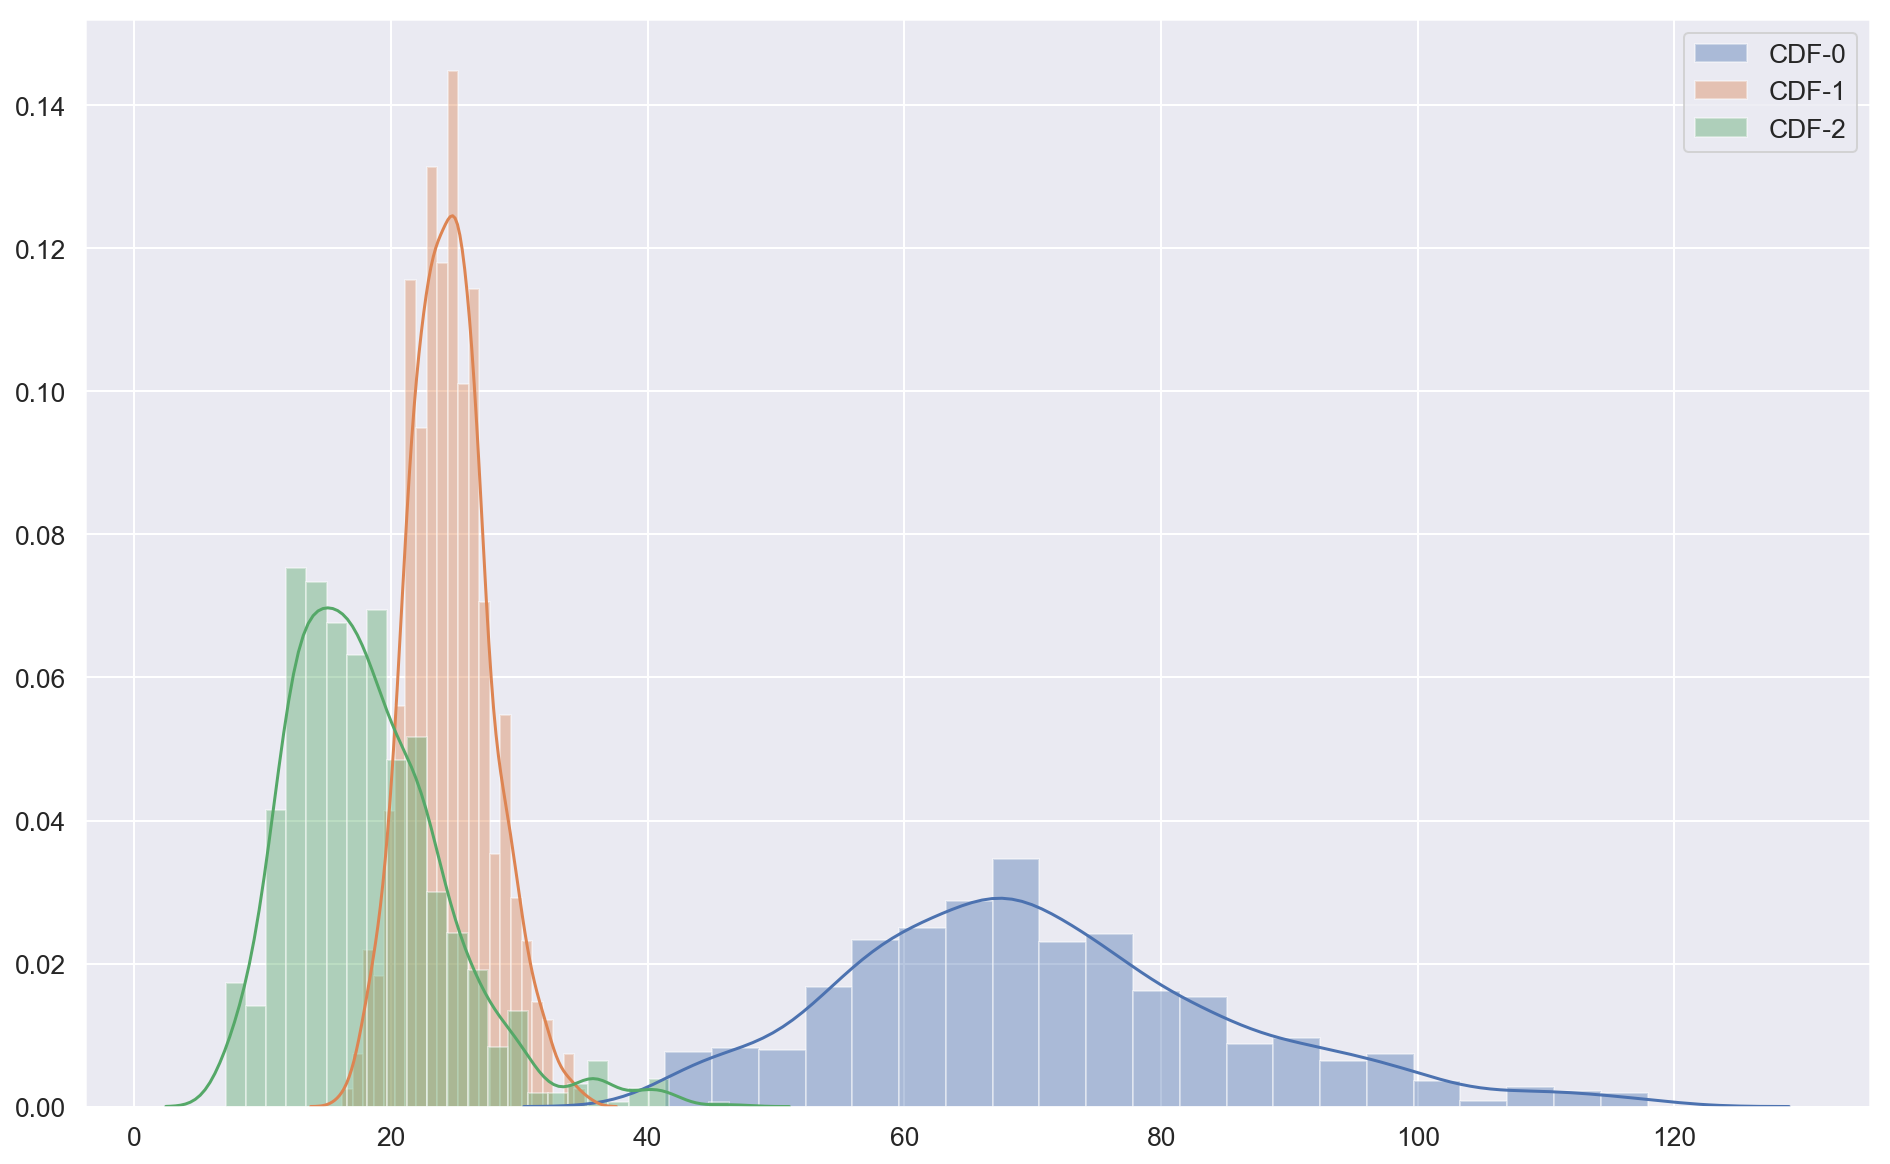

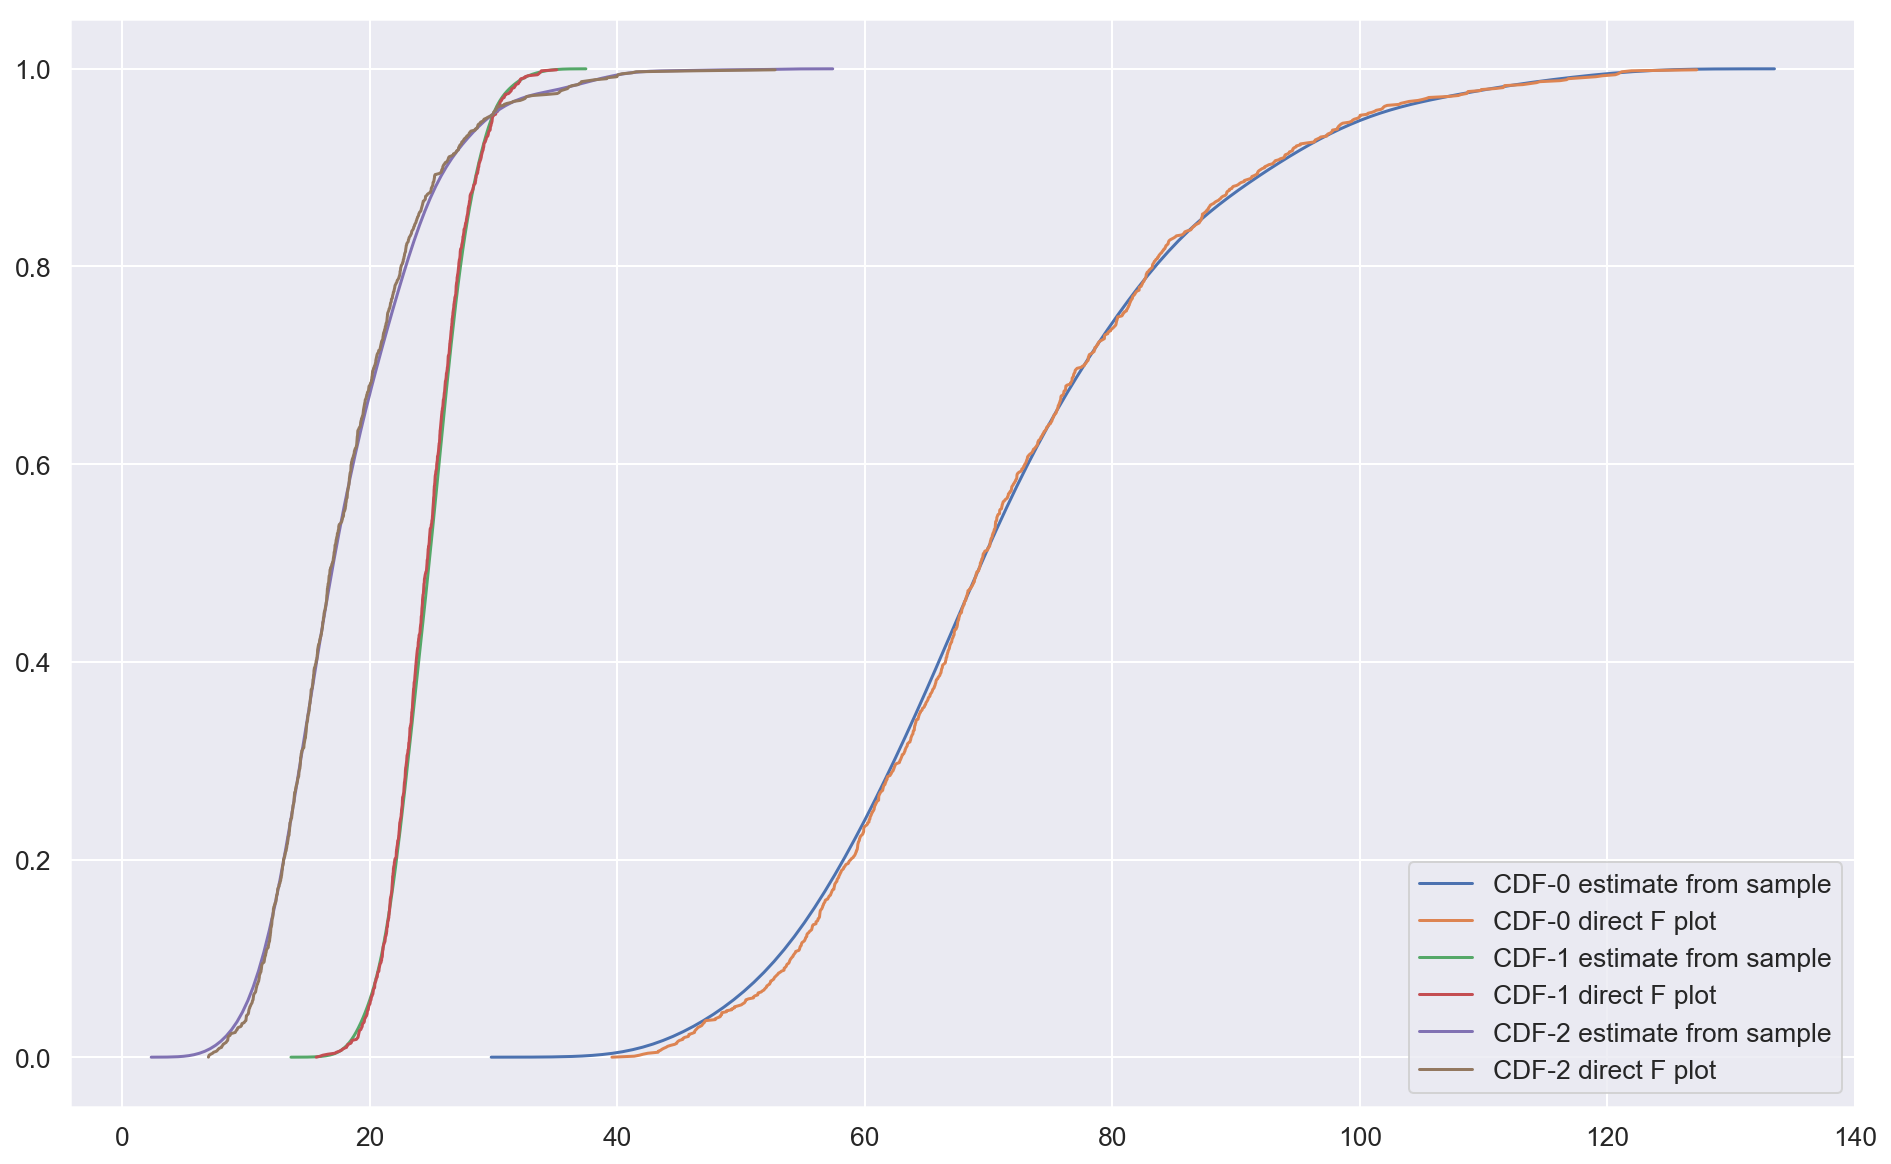

In [12]:
plt.figure()
for i, cdf in enumerate(cdfs):
    sample = cdf.rvs(1000)
    sns.distplot(sample, label='CDF-{}'.format(i))
plt.legend()

plt.figure()
for i, cdf in enumerate(cdfs):
    sample = cdf.rvs(1000)
    sns.kdeplot(sample, cumulative=True, label='CDF-{} estimate from sample'.format(i))
    sns.lineplot(cdf.x, cdf.F, label='CDF-{} direct F plot'.format(i))
plt.legend();



Now let's test the combination method.

We showed that the rvs method works. Now we'll use it to validate the __combine__ method.

When we take a random sample from our combined CDF (result of __combine__) and compare it to a sample from a mixture of the CDF, we should get very similar CDF plots.

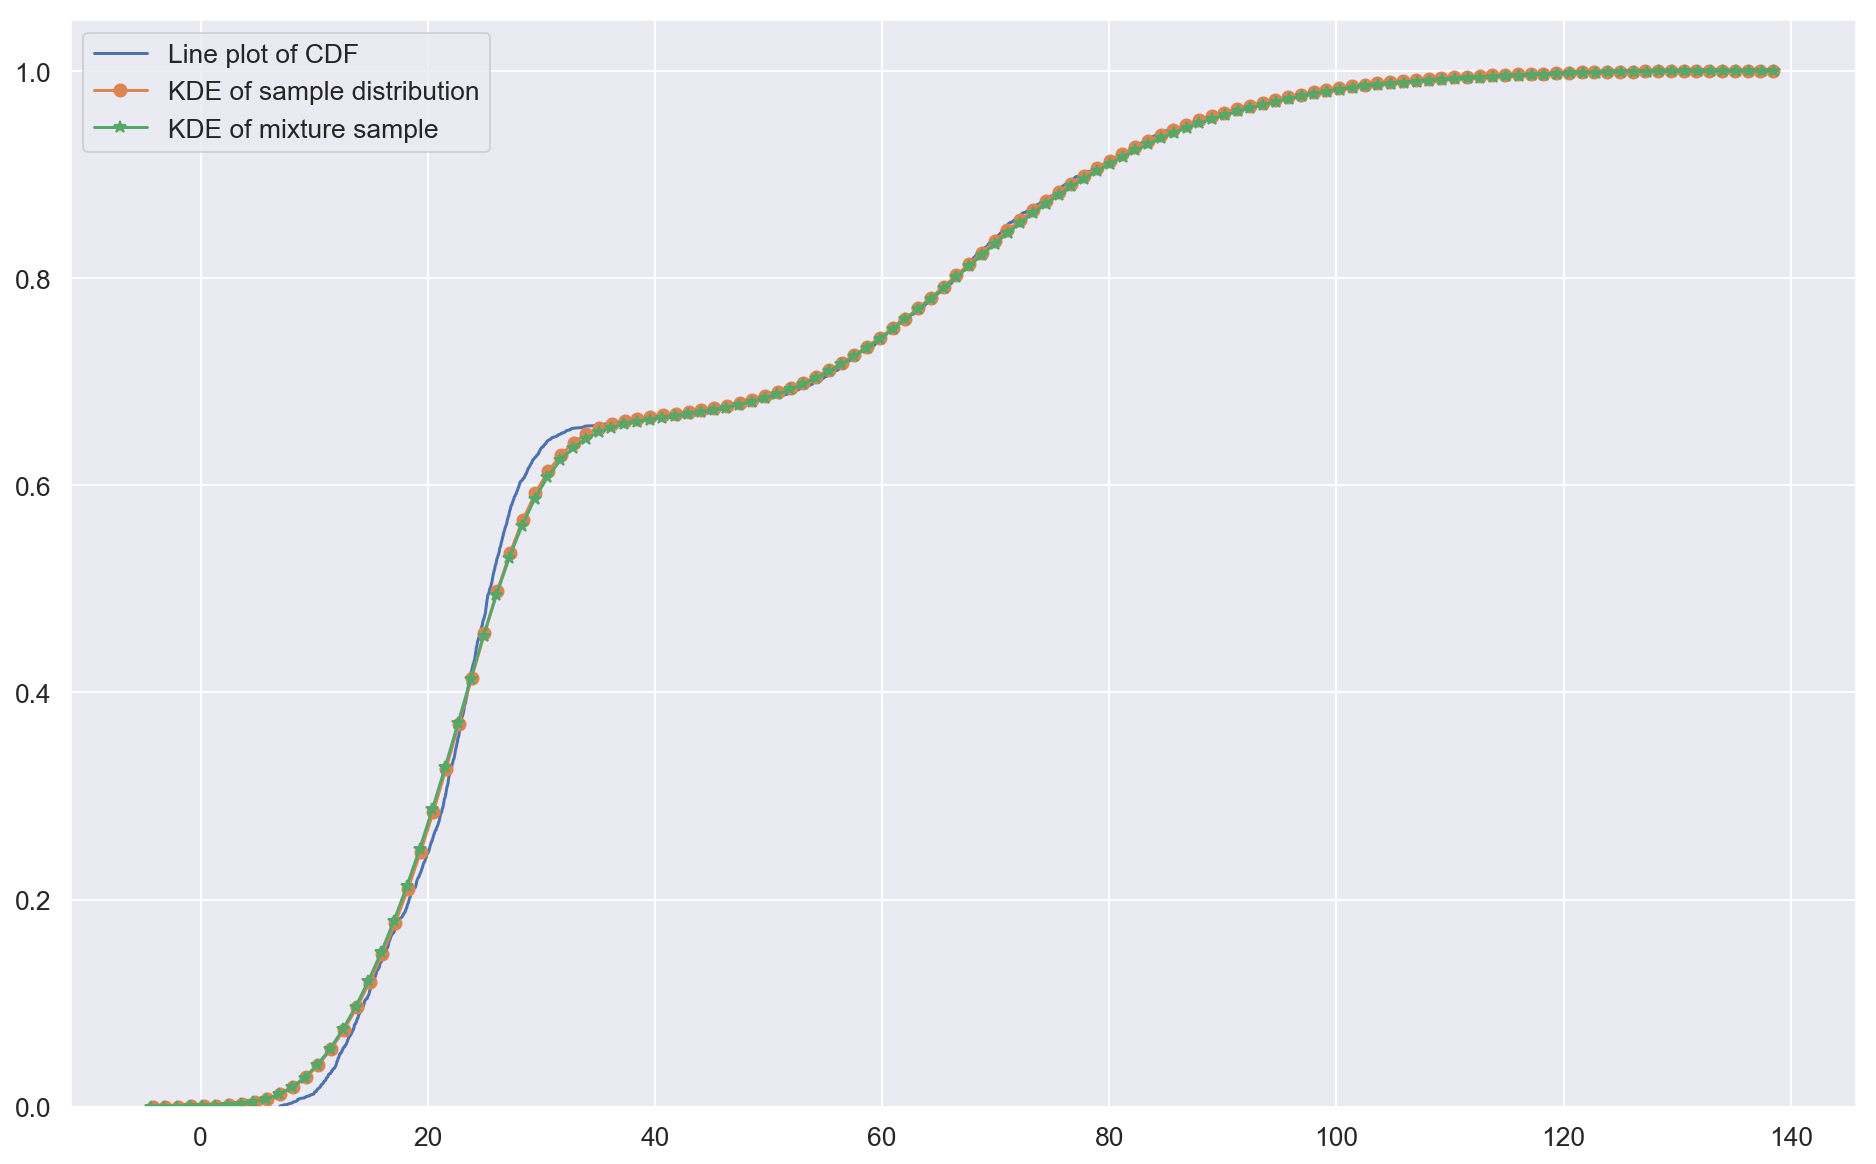

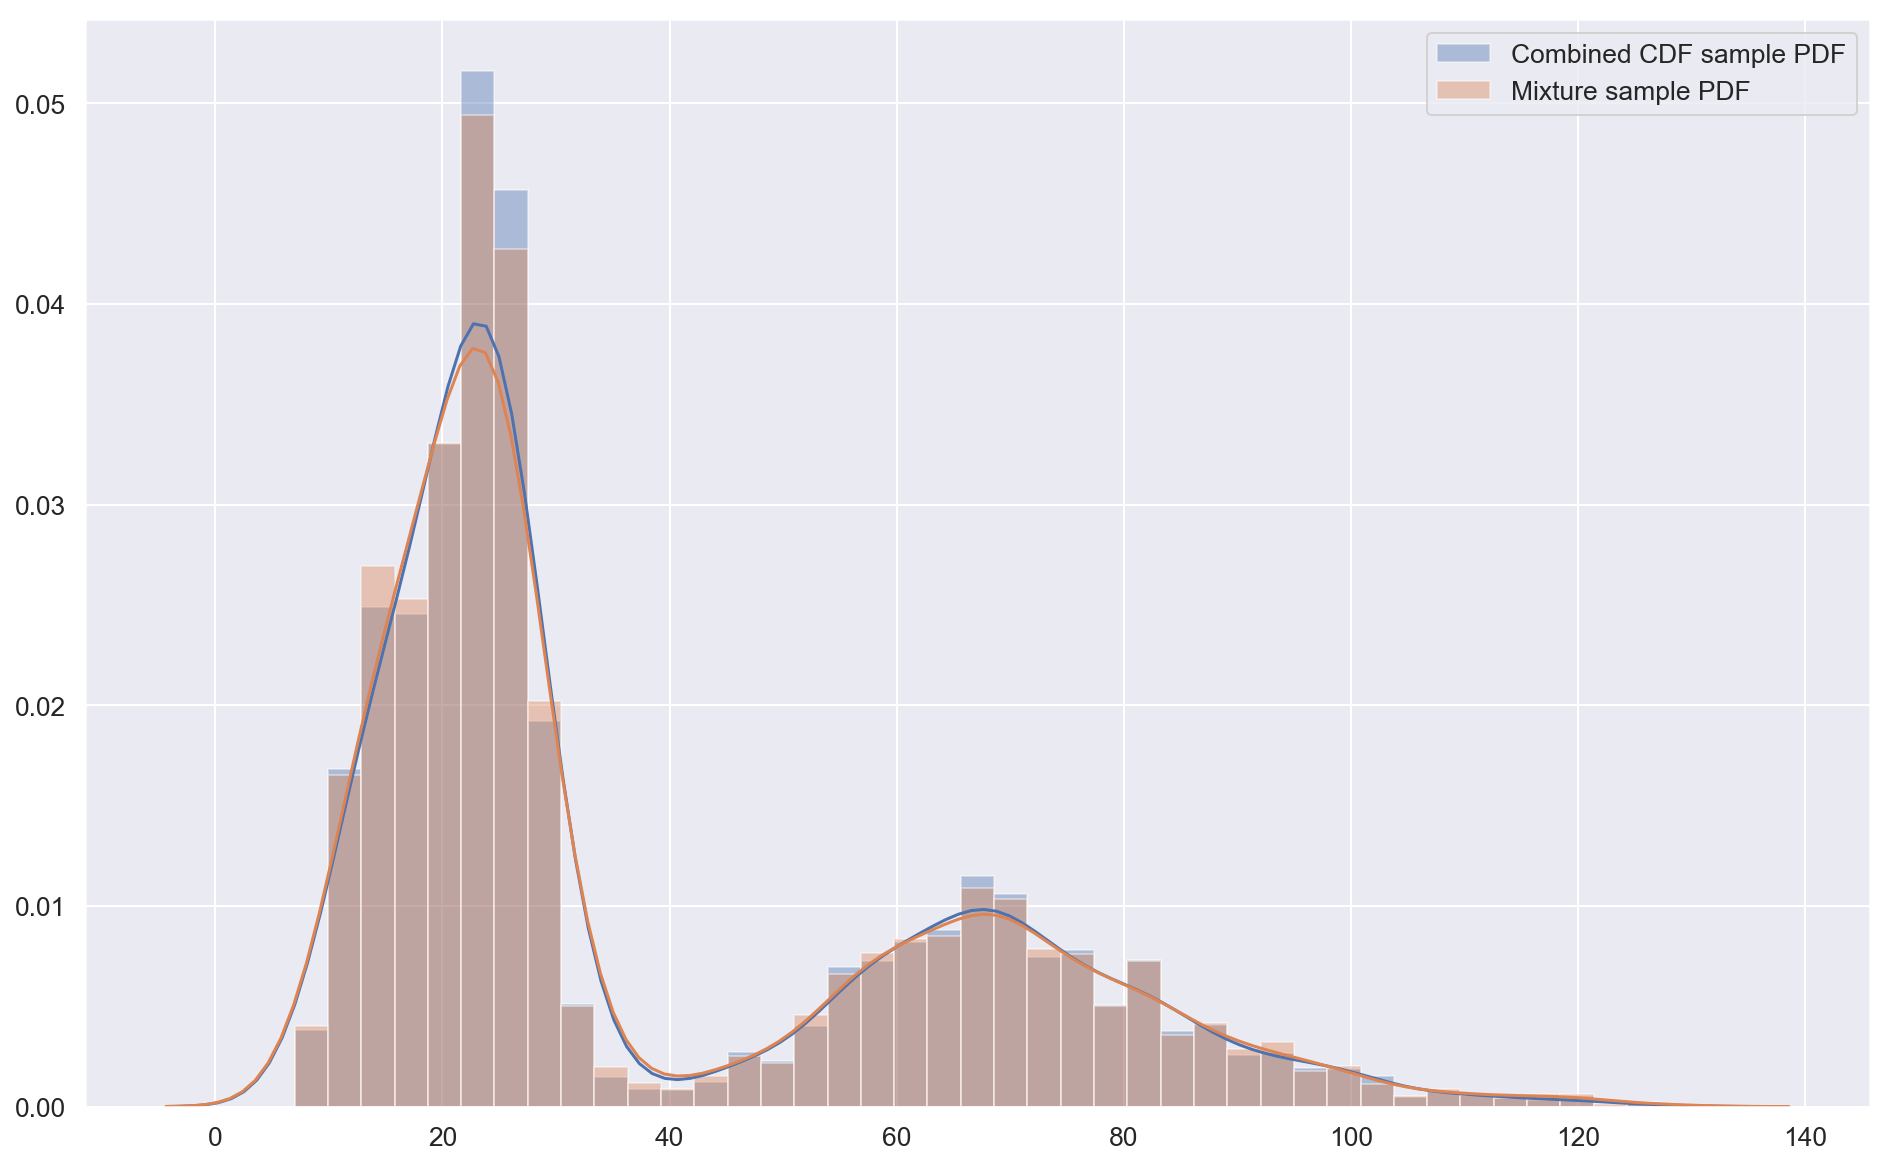

In [7]:
combined = CDF.combine(cdfs) # Create the combined CDF

plt.plot(combined.x, combined.F, label='Line plot of CDF') # Just plot the values of x and F for our combined CDF

combined_cdf_sample = combined.rvs(20000) # Sample from the combined CDF
sns.kdeplot(combined_cdf_sample, cumulative=True, label='KDE of sample distribution', marker='o') # Plot CDF of our samnple


# Simulate sampling from a mixture
def mixture_rvs(cdfs, weights, n):
    weights = np.array(weights)
    weights = weights / np.sum(weights) # make sure weights are normalized
    
    res = []
    for i in range(n):
        # choose distribution from which to sample
        p = np.random.random()
        c_sum = 0
    
        for ind, w in enumerate(weights):
            c_sum += w
            if c_sum >= p:
                selected_cdf = cdfs[ind]
                break
        
        # Now take a sample from the selected distribution
        r = selected_cdf.rvs(n=1)
        res.append(r)
    
    return np.array(res)

mixture_weights = [1.0/len(cdfs) for cdf in cdfs] # assign equal mixture weights
mixture_sample = mixture_rvs(cdfs, mixture_weights, 20000) # take a mixture sample
sns.kdeplot(mixture_sample, cumulative=True, label='KDE of mixture sample', marker='*') # Estimate mixture sample CDF
plt.legend()
plt.figure()

# Let's also plot the PDFs of our two samples
sns.distplot(combined_cdf_sample, label='Combined CDF sample PDF')
sns.distplot(mixture_sample, label='Mixture sample PDF')
plt.legend();


Some possible improvements to this first version:
* If we combine _K_ CDFs, and if each one is specified at _N_ points, the resulting CDF can have at most _K*N_ points. This is what you already pointed out in the proposal. For any distribution we can do an interpolation at _P_ equidistant points between _min(X)_ and _max(X)_, so that we get effectivelly the same CDF but resampled.
* It's also worth considering how the input representations are made, and perhaps make a much larger sample and do equidistant binning of x axis, so that we get a more regular represenation to be fed to later steps
* If it's going to be a background job, there might be some performance improvements possible for the __combine__ method
* Depending on how this should be integrated with the rest of the system, some input validation on __xs__ and __ys__ should be implemented to make sure they're in the admissible range
